## Identifying Locations of Overdoses in Las Vegas
### John Girard, Shikha Pandey, Zack Bunn
##### Southern Methodist University
##### Fall, 2023

In [58]:
# Install python packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from io import StringIO
from wordcloud import WordCloud
from sklearn import metrics

import spacy
from spacy import displacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from nltk.tokenize import word_tokenize

import requests
import json

import en_core_web_sm
from geopy import distance
import joblib
import re
import nltk
import ktrain
import tensorflow as tf
from sklearn.cluster import KMeans

from timeit import default_timer as timer
from datetime import timedelta

import gmaps

In [59]:
# Google developer API key required to call the Google Maps API
# from config import gkey

In [60]:
# Read in Google developer API key required to call the Google Maps API
 
with open("gkey.txt") as file:
    gkey = file.read()

In [61]:
#pip install config

In [62]:
# Import data
# df = pd.read_excel('DataTable_4856_29_05_2023_CY2017-2023_NV_CLARK_WASHOE_35000_overdose.xlsx')
df = pd.read_excel('Overdose_Data_With_Location.xlsx')

C:\Software\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [63]:
df.shape

(35579, 12)

In [64]:
# First 3 rows of the dataset
df.head(3)

,Date,Time,Facility Name,Unnamed: 3,Unnamed: 4,Unnamed: 5,ChiefComplaintOrig,ChiefComplaintParsed,Location,Category_flat,SubCategory_flat,Discharge Diagnosis
0,2023-05-28,1970-01-01 05:03:00,NV-Mountain View Hospital,NaN,0.0,NaN,TOXIC METABOLIC ENCEPHOLP NARCOTIC OD,TOXIC METABOLIC ENCEPHOLP NARCOTIC OVERDOSE,0,;Injury;,;Poisoning;,NaN
1,2023-05-28,1970-01-01 04:21:00,NV-UMCSN Hospital Emergency Department-ER,NaN,0.0,NaN,OVERDOSE,OVERDOSE,0,;Injury;,;Poisoning;,;6471006;59274003;35489007;82313006;110483000;...
2,2023-05-27,1970-01-01 23:08:00,NV-UMCSN Hospital Emergency Department-ER,NaN,0.0,NaN,unwitnessed syncopal episode 4 hours ago. pt c...,UNWITNESSED SYNCOPAL EPISODE 4 AGO PATIENT COM...,0,;Shk_coma;,;LossOfConsciousness;,;E86.0;E86.0;E87.6;E11.22;E78.00;F17.200;N18.9...


In [65]:
# Find nulls
df.isnull().sum()

Date                        0
Time                        0
Facility Name               0
Unnamed: 3              35579
Unnamed: 4              34090
Unnamed: 5              33571
ChiefComplaintOrig        886
ChiefComplaintParsed      896
Location                    0
Category_flat               3
SubCategory_flat         4323
Discharge Diagnosis      1808
dtype: int64

Based on discussions and information from subject matter knowledge expert, most import fields for further analysis are 'ChiefComplaintOrig', and 'ChiefComplaintParsed' fields because they have the hospital notes from when a patient was admitted and might contain information related to location.<br>
In further analysis to check the accuracy of our location prediction, we took help of local Las Vegas residents to flag data in 'Location' field and updated it with 1 if a location was found and 0 otherwise. <br> 'Unnamed' columns in the data are just blank excel columns and can be removed. The remaining fields can be removed as well.

In [66]:
# Create a reduced dataframe with select relevant fields
df = df[['Date','Time','Facility Name','ChiefComplaintOrig','ChiefComplaintParsed','Location']]

In [67]:
# Check the dataset shape for the reduced dataframe
df.shape

(35579, 6)

In [68]:
# Check the datatypes of selected columns in the reduced dataframe
df.dtypes

Date                    datetime64[ns]
Time                    datetime64[ns]
Facility Name                   object
ChiefComplaintOrig              object
ChiefComplaintParsed            object
Location                         int64
dtype: object

In [69]:
# Quick glance on first 3 rows of newly created dataset
df.head(3)

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location
0,2023-05-28,1970-01-01 05:03:00,NV-Mountain View Hospital,TOXIC METABOLIC ENCEPHOLP NARCOTIC OD,TOXIC METABOLIC ENCEPHOLP NARCOTIC OVERDOSE,0
1,2023-05-28,1970-01-01 04:21:00,NV-UMCSN Hospital Emergency Department-ER,OVERDOSE,OVERDOSE,0
2,2023-05-27,1970-01-01 23:08:00,NV-UMCSN Hospital Emergency Department-ER,unwitnessed syncopal episode 4 hours ago. pt c...,UNWITNESSED SYNCOPAL EPISODE 4 AGO PATIENT COM...,0


Checking data for some regex patters and replacing it with null

In [70]:
# Checking when ChiefComplaintOrig column contains only a regex pattern
pattern = r"^['0,.]+$"
df[df['ChiefComplaintOrig'].str.match(pattern, na=False)]

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location
3217,2022-12-17,1970-01-01 23:53:00,NV-Valley Hospital Medical Center,.,NaN,0
3705,2022-11-18,1970-01-01 09:52:00,NV-Northeastern Nevada Regional Hospital,.,NaN,0
5392,2022-08-20,1970-01-01 00:46:00,NV-Sunrise Hospital & Medical Center,.,NaN,0
7117,2022-05-12,1970-01-01 22:50:00,NV-Incline Village Community Hospital,.,NaN,0
7726,2022-04-07,1970-01-01 16:18:00,NV-Renown Regional Er,.,NaN,0
9495,2021-12-16,1970-01-01 13:38:00,NV-Valley Hospital Medical Center,0,NaN,0
13241,2021-04-27,1970-01-01 05:54:00,NV-CTH CARSON TAHOE REGIONAL MEDICAL CENTER,.,NaN,0
23625,2019-05-30,1970-01-01 11:19:00,NV-Valley Hospital Medical Center,.,NaN,0
24932,2019-03-01,1970-01-01 11:31:00,NV-Henderson Hospital,.,NaN,0
30996,2017-12-23,1970-01-01 07:36:00,NV-Centennial Hills Hospital Medical Center,0,SUICIDAL IDEATION WITH PLAN TO OVERDOSE ON SLE...,0


In [71]:
# Getting the indices of rows where the regex pattern was found
filtered_indices = df[df['ChiefComplaintOrig'].str.match(pattern, na=False)].index

# Replace values in the 'ChiefComplaintOrig' column with null for the filtered rows
df.loc[filtered_indices, 'ChiefComplaintOrig'] = np.nan

In [72]:
# Checking when ChiefComplaintParsed column contains only a regex pattern
df[df['ChiefComplaintParsed'].str.match(pattern, na=False)]

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location


ChiefComplaintParsed column doesn't have data with provided regex pattern

#### Null Values

In [73]:
# Check for the null values in the reduced dataset
df.isnull().sum()

Date                      0
Time                      0
Facility Name             0
ChiefComplaintOrig      896
ChiefComplaintParsed    896
Location                  0
dtype: int64

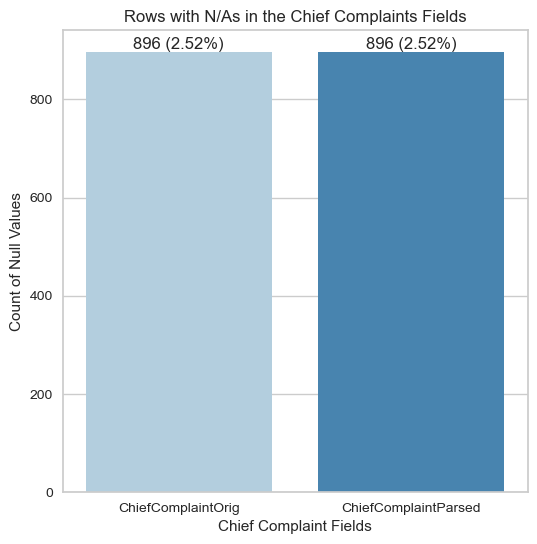

In [74]:
# Chief Complaint fields with null values
cc_orig = df.isnull().sum()[3]
cc_parsed = df.isnull().sum()[4]

# Calculate the percentage of null values
total_rows = len(df)
cc_orig_percentage = (cc_orig / total_rows) * 100
cc_parsed_percentage = (cc_parsed / total_rows) * 100

# plot the Chief Complaint fields
data = [cc_orig, cc_parsed]
labels = ['ChiefComplaintOrig', 'ChiefComplaintParsed']

# Create the bar plot
plt.figure(figsize=(6,6))
ax = sns.barplot(x=labels, y=data, palette="Blues")
plt.title('Rows with N/As in the Chief Complaints Fields')
plt.ylabel('Count of Null Values')
plt.xlabel('Chief Complaint Fields')

# Annotate the bars with percentage values
for i, v in enumerate(data):
    ax.text(i, v + 1, f'{v} ({data[i]/total_rows*100:.2f}%)', ha='center', va='bottom')

plt.show()

<blockquote>This plot shows the number and percentage of null values for each Chief Complaint field.</blockquote>

The rows with null values in these fields will not be kept further in the analysis, because these are the only 2 fields that contain information about Location, if any. If they are null then they don't provide any additional input to the models and so, those rows of data can be removed from the dataset.

In [75]:
# filtered_df1 = df[(df['ChiefComplaintOrig'].isnull()) & (df['ChiefComplaintParsed'].notna())]
# filtered_df1

In [76]:
# filtered_df2 = df[(df['ChiefComplaintParsed'].isnull()) & (df['ChiefComplaintOrig'].notna())]
# filtered_df2

In [77]:
# Drop rows where 'ChiefComplaintOrig' is null
# df = df.dropna(subset=['ChiefComplaintOrig'])

# Drop all rows where columns 'ChiefComplaintOrig' and 'ChiefComplaintParsed' are null
df = df.dropna()

#Check the shape now
df.shape

(34682, 6)

In [78]:
# Check for null values
df.isnull().sum()

Date                    0
Time                    0
Facility Name           0
ChiefComplaintOrig      0
ChiefComplaintParsed    0
Location                0
dtype: int64

In [ ]:
# replace nulls with ''
# df = df.fillna("")

In [ ]:
# find nulls
# df.isnull().sum()

#### Duplicate Values

In [79]:
# find duplicates
df.duplicated().sum()

10

In [80]:
# identify duplicate rows
df[df.duplicated()]

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location
5846,2022-07-27,1970-01-01 00:50:00,NV-Valley Hospital Medical Center,Drug Overdose,DRUG OVERDOSE,0
18138,2020-06-09,1970-01-01 09:16:00,NV-Valley Hospital Medical Center,PT PICKED UP BY EMS FOUND DOWN ON THE STREET B...,PATIENT PICKED UP BY EMS FOUND DOWN ON STREET ...,0
31955,2017-10-11,1970-01-01 01:12:00,NV-Desert Springs Hospital Medical Center,OD,OVERDOSE,0
34840,2017-03-07,1970-01-01 10:57:00,NV-Summerlin Hospital Medical Center,seizures x 2; last one an hour ago; per EMS pt...,SEIZURES 2 LAST ONE AGO PER EMS PATIENT WAS UN...,0
34927,2017-02-27,1970-01-01 22:24:00,NV-St. Rose Dominican Hospitals - Rose De Lima...,TYLENOL OVERDOSE,TYLENOL OVERDOSE,0
35112,2017-02-11,1970-01-01 02:39:00,NV-Mesa View Regional Hospital,OVERDOSE,OVERDOSE,0
35211,2017-02-01,1970-01-01 20:42:00,NV-Sunrise Hospital & Medical Center,H OVERDOSE/S/P NARCAN,H OVERDOSE STATUS POST NARCAN,0
35241,2017-01-31,1970-01-01 02:03:00,NV-Desert Springs Hospital Medical Center,ETOH AMS Posible OD of unknown substance.,ALCOHOL ALTERED MENTAL STATUS POSIBLE OVERDOSE...,0
35432,2017-01-14,1970-01-01 13:22:00,NV-Spring Valley Hospital Medical Center,per EMS pt was at a friend's house taking a sh...,PER EMS PATIENT WAS AT A FRIEND S HOUSE TAKING...,0
35453,2017-01-12,1970-01-01 22:20:00,NV-Valley Hospital Medical Center,AMS ALCOHOL INTOXICATION UNSTEADY GAIT; PT PIC...,ALTERED MENTAL STATUS ALCOHOL INTOXICATION UNS...,0


In [81]:
# Drop duplicate rows while keeping the original one
df = df.drop_duplicates(keep='first')

# Check the dataset shape after removing duplicates
df.shape

(34672, 6)

+ We are going to save this dataset and it will be used for further exploratory data analysis (EDA). This will also be used a our final dataset to predict locations.

In [82]:
# Saving the cleaned dataset
df.to_csv('full_cleaned_data.csv', index=False)

The most number of hospital records for overdose patient admission in the data are from Valley Hospital Medical Center.

In [83]:
# Counts of records for each facility
df['Facility Name'].value_counts()

NV-Valley Hospital Medical Center                                          4281
NV-Sunrise Hospital & Medical Center                                       3719
NV-Spring Valley Hospital Medical Center                                   3070
NV-Renown Regional Er                                                      2980
NV-Desert Springs Hospital Medical Center                                  2352
NV-Henderson Hospital                                                      1814
NV-Summerlin Hospital Medical Center                                       1738
NV-Mountain View Hospital                                                  1734
NV-Centennial Hills Hospital Medical Center                                1680
NV-St. Mary's Regional Medical Center                                      1408
NV-UMCSN Hospital Emergency Department-ER                                  1390
NV-St. Rose Dominican Hospitals - Siena Campus                             1109
NV-North Vista Hospital                 

In [84]:
# plot the number of overdose cases by year
df['Year'] = pd.DatetimeIndex(df['Date']).year

Below is the number of cases by year.

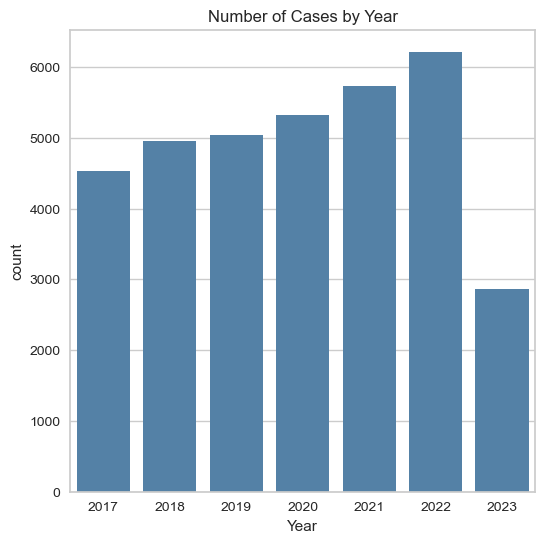

In [85]:
plt.figure(figsize=(6,6))
ax = sns.countplot(x='Year', data=df, color='steelblue').set(title='Number of Cases by Year')

<blockquote>The plot above shows the number of records for each year in the data. We can see continuous rise in number of cases in past 6 years. Year 2023 isn't complete yet and data is as of May.</blockquote>

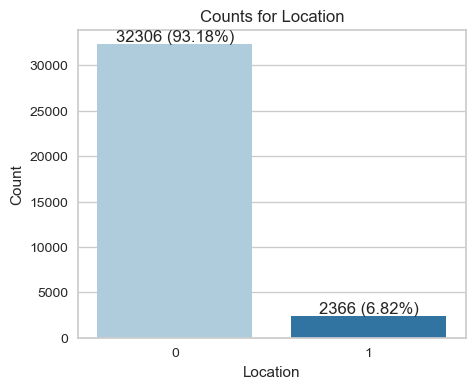

In [86]:
# Check the distribution for Location

total_count = len(df)
value_counts = df['Location'].value_counts()
percentages = (value_counts / total_count) * 100

sns.set_palette("Paired")
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Location', data=df, order=value_counts.index, saturation=0.75)
ax.set(xlabel='Location', ylabel='Count', title='Counts for Location')

# Annotate the bars with count and percentage values
for i, v in enumerate(value_counts):
    ax.text(i, v + 1, f'{v} ({percentages.iloc[i]:.2f}%)', ha='center', va='bottom')

plt.show()

<blockquote>The plot above shows the distribution for Location availability in the data. Only less than 7% of data has location present.</blockquote>

### Most Common Words in the Dataset

The top 10 words by frequency in 'ChiefComplaintsOrig' field are shown below. Stopwords like "the", "a", and "of" are not included. "pt" (i.e. patient) is the most frequent term, followed by "overdose", and "ems" (i.e. Emergency Medical Services). 

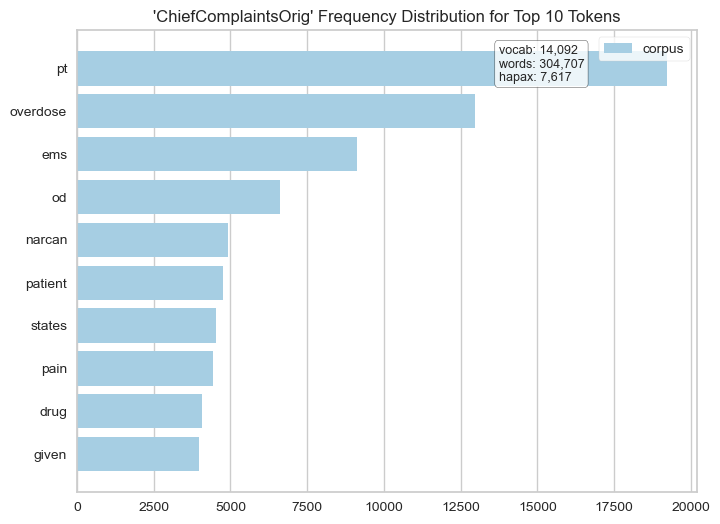

<AxesSubplot:title={'center':"'ChiefComplaintsOrig' Frequency Distribution for Top 10 Tokens"}>

In [87]:
#frequency distribution plot - ChiefComplaintOrig
corpus_cc_orig = df['ChiefComplaintOrig'].tolist()


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(corpus_cc_orig)
features   = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10, size=(800, 600), title="'ChiefComplaintsOrig' Frequency Distribution for Top 10 Tokens")
visualizer.fit(docs)
visualizer.show()

The most frequent words in the 'ChiefComplaintParsed' field are almost identical to the 'ChiefComplaintOrig' field. As we can see below "pt" is expanded to "patient" in this field.

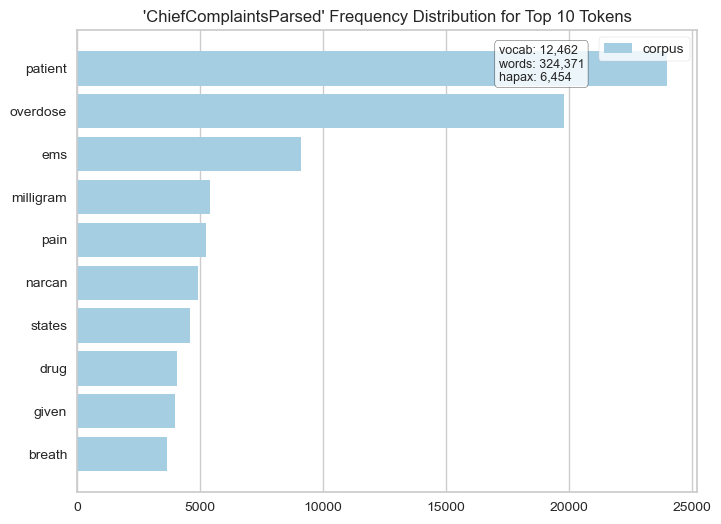

<AxesSubplot:title={'center':"'ChiefComplaintsParsed' Frequency Distribution for Top 10 Tokens"}>

In [88]:
#Frequency distributioin plot - ChiefComplaintParsed
corpus_cc_parsed = df['ChiefComplaintParsed'].tolist()


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(corpus_cc_parsed)
features   = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10, size=(800, 600), title="'ChiefComplaintsParsed' Frequency Distribution for Top 10 Tokens")
visualizer.fit(docs)
visualizer.show()

Here is how the word cloud of the most common words in this dataset looks like.

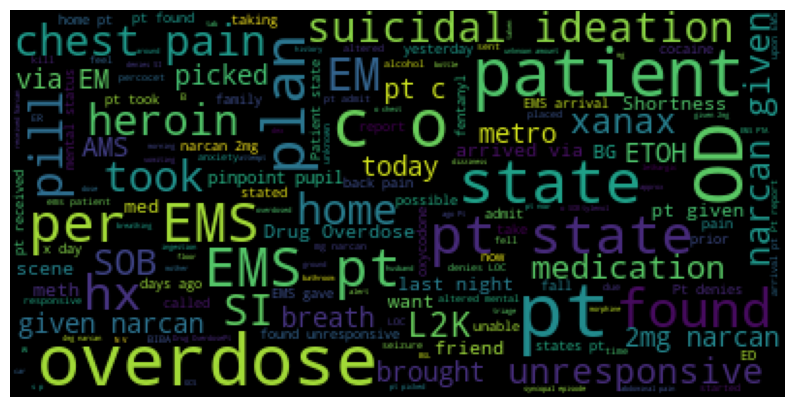

In [90]:
#get words
si=StringIO()
df['ChiefComplaintOrig'].apply(lambda x: si.write(str(x)))
s=si.getvalue()
si.close()
s[0:100]
text = s

#Generate a word cloud image
wordcloud = WordCloud().generate(text)

#take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_words=len(s),max_font_size=40, relative_scaling=.5).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud

<blockquote>It is not a surprise that word "overdose" is glaring at us, followed by "patient" and "EMS".</blockquote>

In [118]:
# Import validation dataset
df_v = pd.read_excel('Validation_Dataset.xlsx')

In [119]:
df_v.shape

(6934, 6)

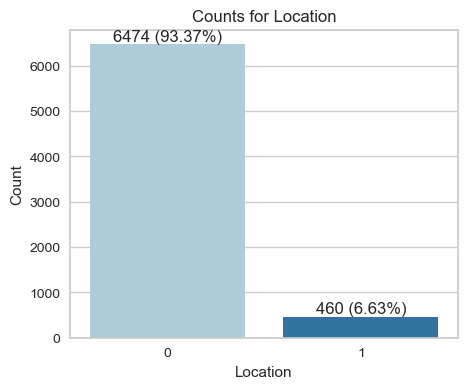

In [120]:
# Check the distribution for Location in validation dataset

total_count = len(df_v)
value_counts = df_v['Location'].value_counts()
percentages = (value_counts / total_count) * 100

sns.set_palette("Paired")
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Location', data=df_v, order=value_counts.index, saturation=0.75)
ax.set(xlabel='Location', ylabel='Count', title='Counts for Location')

# Annotate the bars with count and percentage values
for i, v in enumerate(value_counts):
    ax.text(i, v + 1, f'{v} ({percentages.iloc[i]:.2f}%)', ha='center', va='bottom')

plt.show()

In [ ]:
# plt.figure(figsize=(6,6))
# ax = sns.countplot(x='Year', data=df_v, color='steelblue').set(title='Number of Cases by Year')

In [121]:
# Add columns for index, logtitude and latitude in validation dataset
df_v = df_v.assign(Index = 0, label_lat = np.nan, label_lon = np.nan)
df_v['label_lat'] = df_v['label_lat'].astype(float)
df_v['label_lon'] = df_v['label_lon'].astype(float)

# Handling data format for logtitude and latitude
df_v['label_lat'] = df_v['label_lat'].round(decimals = 4)
df_v['label_lon'] = df_v['label_lon'].round(decimals = 4)

In [122]:
# Add columns for count of words in ChiefComplaintOrig and ChiefComplaintParsed fields
df_v['len_cco'] = df_v['ChiefComplaintOrig'].str.len()
df_v['len_ccp'] = df_v['ChiefComplaintParsed'].str.len()

In [123]:
# Rearranging columns in validation dataframe
df_v = df_v[['Index', 'Date', 'Time', 'Facility Name', 'ChiefComplaintOrig',
       'ChiefComplaintParsed', 'Location', 'label_lat',
       'label_lon', 'len_cco', 'len_ccp']]

In [99]:
df_v.head(3)

,Index,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location,label_lat,label_lon,len_cco,len_ccp
0,0,2023-05-28,1970-01-01 05:03:00,NV-Mountain View Hospital,TOXIC METABOLIC ENCEPHOLP NARCOTIC OD,TOXIC METABOLIC ENCEPHOLP NARCOTIC OVERDOSE,0,NaN,NaN,37.0,43
1,0,2023-05-28,1970-01-01 04:21:00,NV-UMCSN Hospital Emergency Department-ER,OVERDOSE,OVERDOSE,0,NaN,NaN,8.0,8
2,0,2023-05-27,1970-01-01 21:35:00,NV-Spring Valley Hospital Medical Center,C/o Suicidal Ideation. Patient states he attem...,COMPLAINS OF SUICIDAL IDEATION PATIENT STATES ...,0,NaN,NaN,139.0,141


In [124]:
# Copy validation data into new dataframes for each model
df_sp = df_v.copy()
df_crf = df_v.copy() 
df_gzt = df_v.copy()
df_ktr = df_v.copy()
df_sp_ccp = df_v.copy()
df_crf_ccp = df_v.copy()
df_gzt_ccp = df_v.copy()
df_ktr_ccp = df_v.copy()

In [125]:
# New dataframe with the count of characters for Chief Complaint fields
len_df = pd.melt(df_v, id_vars=['Location'], value_vars=['len_cco', 'len_ccp'])

<AxesSubplot:xlabel='variable', ylabel='value'>

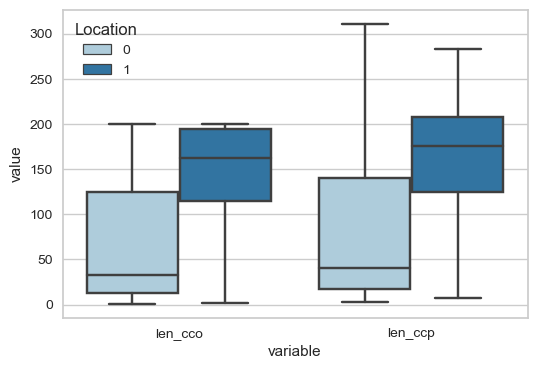

In [126]:
# Boxplots for label and character counts
plt.figure(figsize=(6,4))
sns.boxplot(x='variable', y='value', hue='Location', data=len_df)

## Model Building and Evaluations

Running the NER models and getting the geographical coordinates from Google.

#### Common Functions

In [127]:
# Load the en_core_web_sm spacy model
nlp = spacy.load("en_core_web_sm")

In [128]:
# Create a stopwords list of terms to exclude
exclude_list = ['Metro Police','Metro police','Metro','metro','MEtro','PD','AMS','EMS','ems','BIBA','Biba','biba','ED','ed','ABX','abx','L2K','L2 K','L2k','l2k','BG','bg','BGL','bgl','CIA','FBI','fbi','ER','er','SI','si','ABCD','EMT','ETOH','etoh','TRFR','trfr','TRF','trf','GUN','Gun','LLE','lle','LVMPD','ASSAULTED','ASSAULT','Assault','KNIFE','PTA','STD','ABD']

spaCy - Get Location Named Entities

In [129]:
# Takes in a string and a type of location (GPE, LOC, FAC, ORG), runs NER, returns a string of the named entity 
def get_spacy_ner(text, type):
    """Returns a Named Entity string"""
    doc = nlp(text)
    org_list = [(X.text) for X in doc.ents if X.label_ in type and X.text not in exclude_list]
    string = ', '.join(str(e) for e in org_list)
    return string

Custom NER with CRF - Get Locations

In [130]:
# Takes in a string and returns a list of geos
def get_geos(text):
    """Returns a list of -geo tags"""
    text = re.sub(r'\n', '', text)
    text_tokens = nltk.word_tokenize(text)
    text_pos = nltk.pos_tag(text_tokens)
    
    #extract features from POS tagged text document
    features = [sent2features(text_pos)]
    
    #use trained model to predict features engineered
    labels = crf.predict(features)
    doc_labels = labels[0]

    text_ner = [(token, tag) for token, tag in zip(text_tokens, doc_labels)]
    
    named_entities = []
    temp_entity_name = ''
    temp_named_entity = None
    
    for term, tag in text_ner:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
                
    #iterate through the named entities and extract the geo entities         
    geo_list = []
    for x in named_entities:
        if 'geo' in x[1] and x[0] not in exclude_list: 
            geo_list.append(x[0])
        elif 'org' in x[1] and x[0] not in exclude_list and not x[0].isupper(): 
            geo_list.append(x[0])
        elif 'gpe' in x[1] and x[0] not in exclude_list: 
            geo_list.append(x[0])
        else:
            geo_list.append('')
    return(geo_list)

Get Coordinates from Google Maps API

In [131]:
# Takes the NER location text field and passes it to the Google Maps API
def get_coords(text):
    coords = (np.nan, np.nan)
    try:
        address = text + " Las Vegas, NV"

        #build the endpoint URL
        target_url = ('https://maps.googleapis.com/maps/api/geocode/json?''address={0}&key={1}').format(address, gkey)
        
#         print(target_url)

        #send request to endpoint and convert result to json
        geo_data = requests.get(target_url).json()
        
        #extract the lat and lng
        lat = geo_data["results"][0]["geometry"]["location"]["lat"]
        lng = geo_data["results"][0]["geometry"]["location"]["lng"]
        loc_type = geo_data["results"][0]["geometry"]["location_type"]
        long_name = geo_data["results"][0]["address_components"][0]["long_name"]
        if loc_type == 'APPROXIMATE' and long_name == 'Las Vegas':
            coords = (np.nan, np.nan)
        else:
            coords = (lat, lng)
        print(coords, loc_type, long_name)
        print("---------------")

    except:
        coords = (np.nan, np.nan)
    return coords

Call Google with the spaCy NERs

In [132]:
# Takes a df input and passes the NER location to the get_coords function (calling Google)
# Sets the lat/lon column if found
def call_google_api(df):
    start = timer()
    coords = []
    for i, row in df.iterrows():
        if df['Streets'].iloc[i] != "":
            coords = get_coords(df['Streets'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['FACs'].iloc[i] != "":
            coords = get_coords(df['FACs'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['LOCs'].iloc[i] != "":
            coords = get_coords(df['LOCs'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['GPEs'].iloc[i] != "":
            coords = get_coords(df['GPEs'].iloc[i] )
            df_sp.at[i,'lat'] = coords[0]
            df_sp.at[i,'lon'] = coords[1]
        elif df['Orgs'].iloc[i] != "":
            coords = get_coords(df['Orgs'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        else:
            coords = (np.nan, np.nan)
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
    end = timer()
    print(timedelta(seconds=end-start))

Call Google with the Custom NER

In [133]:
# Takes a df input and passes the NER location to the get_coords function (calling Google)
# Sets the lat/lon column if found
def call_google_api_custom(df):
    start = timer()
    coords = []
    for i, row in df.iterrows():
        if df['Loc1'].iloc[i] != "":
            coords = get_coords(df['Loc1'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        else:
            coords = (np.nan, np.nan)
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
    end = timer()
    print(timedelta(seconds=end-start))

Call Google with the Ktrain NER

In [134]:
# Takes a df input and passes the NER location to the get_coords function (calling Google)
# Sets the lat/lon column if found
def call_google_api_ktrain(df):
    coords = []
    for i, row in df.iterrows():
        if df['Loc4'].iloc[i] != "":
            coords = get_coords(df['Loc4'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['Loc1'].iloc[i] != "":
            coords = get_coords(df['Loc1'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['Loc3'].iloc[i] != "":
            coords = get_coords(df['Loc3'].iloc[i] )
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['Loc2'].iloc[i] != "":
            coords = get_coords(df['Loc2'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        else:
            coords = (np.nan, np.nan)
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]

Get Prediction of 0/1

In [135]:
# Sets 0/1 labels. If there is a lat/lon present, then label = 1. If not present, then label = 0.
def get_prediction(df):
    for i, row in df.iterrows():
        if np.isnan(row['lat']) and np.isnan(row['lon']):
            df.at[i,'pred'] = 0
        else:
            df.at[i,'pred'] = 1

Evaluate Predictions

In [136]:
# Compares the lat/lon found in Google Maps to the label_lat/label_lon provided in the training data
# Sets a value for each row for True Negative (TN), True Positive (TP), False Negative (FN), False Positive (FP)
def pred_eval(df):
    for i, row in df.iterrows():
        lat = df['lat'].iloc[i]
        lon = df['lon'].iloc[i]
        lab_lat = df['label_lat'].iloc[i]
        lab_lon = df['label_lon'].iloc[i]
        lat_null = np.isnan(lat)
        lon_null = np.isnan(lon)
        lab_lat_null = np.isnan(lab_lat)
        lab_lon_null = np.isnan(lab_lon)
        label = df['pred'].iloc[i]

        #TN
        if lat_null and lon_null and lab_lat_null and lab_lon_null and label == 0:
            df.at[i,'pred_eval'] = 'TN'

        #TP
        elif not lat_null and not lon_null and not lab_lat_null and not lab_lon_null and label == 1:
            loc1 = (lab_lat, lab_lon)
            loc2 = (lat, lon)
            dist = distance.distance(loc1, loc2).miles
            if dist <= 1:
                df.at[i,'pred_eval'] = 'TP'
            else: 
                df.at[i,'pred_eval'] = 'FP'

        #FN
        elif lat_null and lon_null and not lab_lat_null and not lab_lon_null and label == 0:
            df.at[i,'pred_eval'] = 'FN'

        #FP
        elif not lat_null and not lon_null and lab_lat_null and lab_lon_null and label == 1:
            df.at[i,'pred_eval'] = 'FP'

        else:
            print('unknown')

Evaluation Metrics

In [137]:
# Uses the TP, TN, FP, FN values to returns Accuracy, Precision, Recall, and F1 scores
# Takes in a df, the model name, and the df column used in the NER
def get_scores(df, model, col):
    preds = df['pred_eval'].value_counts()
    tp = preds.loc['TP']
    tn = preds.loc['TN']
    fp = preds.loc['FP']
    fn = preds.loc['FN']
    acc = round((tp + tn)/(tp + tn + fp + fn),4)
    prec = round(tp / (tp + fp),4)
    rec = round(tp / (tp + fn), 4) 
    f1 = round(2 * (prec * rec) / (prec + rec), 4)
    return [[model, col, acc, prec, rec, f1]]

---------------------------------------

### spaCy NER

This code identifies NER locations using a basic spaCy model. The model is run once for the 'ChiefComplaintOrig' field and once for the 'ChiefComplaintParsed' field.

In [138]:
# Takes in a dataframe and column name and calls the get_spacy_ner function
def run_spacy(df, col):
    start = timer()
    print(col)
    streets = []
    orgs = []
    geo_entities = []
    facs = []
    locs = []

    #loops through the df column passed in and calls the get_spacy_ner function for each spaCy location type (ORG, GPE, FAC, LOC)
    #Adds results to lists
    for i in range(len(df)):
        complaint = df[col].iloc[i].replace("OD", "Overdose").replace("pt", "patient").replace("GSW", "gun shot wound").replace("Metro", "Metro Police").replace("LOC", "loss of control")
        temp_streets = get_spacy_ner(complaint, 'STREET')
        streets.append(temp_streets)
        temp_orgs = get_spacy_ner(complaint, 'ORG')
        orgs.append(temp_orgs)
        temp_geos = get_spacy_ner(complaint, 'GPE')
        geo_entities.append(temp_geos)
        temp_facs = get_spacy_ner(complaint, 'FAC')
        facs.append(temp_facs)
        temp_locs = get_spacy_ner(complaint, 'LOC')
        locs.append(temp_locs)

    #saves the ners back to the df
    df['Streets'] = streets
    df['FACs'] = facs
    df['Orgs'] = orgs
    df['GPEs'] = geo_entities
    df['LOCs'] = locs
    
    end = timer()
    print(timedelta(seconds=end-start))

#### ChiefComplaintOrig

In [139]:
# Pass dataframe and the column name to the run_spacy_ner function
run_spacy(df_sp,'ChiefComplaintOrig')

ChiefComplaintOrig
0:03:03.526400


In [140]:
df_sp.shape

(6934, 16)

In [141]:
print('Number of FACs: ', len(df_sp['FACs'].unique()))
print('Number of Orgs: ', len(df_sp['Orgs'].unique()))
print('Number of GPEs: ',len(df_sp['GPEs'].unique()))
print('Number of LOCs: ', len(df_sp['LOCs'].unique()))

Number of FACs:  61
Number of Orgs:  1289
Number of GPEs:  209
Number of LOCs:  34


In [142]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api(df_sp)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_sp)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_sp)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.1141275, -115.1965118) ROOFTOP 4321
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(36.1678342, -115.156188) ROOFTOP 495
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(31.9685988, -99.9018131) APPROXIMATE Texas
---------------
(36.110132, -115.175128) ROOFTOP 3

(36.1175148, -115.1881593) ROOFTOP 3700
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2093033, -115.1076011) GEOMETRIC_CENTER Las Vegas Boulevard North
---------------
(36.1720189, -115.1298202) GEOMETRIC_CENTER North Maryland Parkway
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1860991, -115.1348596) ROOFTOP 314
---------------
(36.1610061, -115.1527427) GEOMETRIC_CENTER South Main Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
-----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1465268, -115.1599168) GEOMETRIC_CENTER West Baltimore Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1953689, -115.1325336) ROOFTOP 1901
---------------
(36.1585988, -115.2026957) ROOFTOP 4575
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0574196, -115.2720575) ROOFTOP 8280
---------------
(36.1590854, -115.2058635) APPROXIMATE Charleston
---------------
(36.1951676, -115.0205566) ROOFTOP 6901
---------------
(nan, nan) APPROX

(nan, nan) APPROXIMATE Las Vegas
---------------
(31.9685988, -99.9018131) APPROXIMATE Texas
---------------
(36.0574086, -115.1564187) ROOFTOP 340
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1690405, -115.1398293) ROOFTOP 518
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(36.1611352, -115.1514715) ROOFTOP 917
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.213472, -115.248659) ROOFTOP 2880
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) APPROXIMATE Las Vega

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.112462, -115.1707075) ROOFTOP 3655
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.274209, -115.2578537) ROOFTOP 7455
---------------
(36.1452546, -115.1691203) ROOFTOP 2412
---------------
(36.0876717, -115.1722566) ROOFTOP 4605
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1714041, -115.1784423) GEOMETRIC_CENTER Desert View Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(36.1093739, -115.1849684) ROOFTOP 4424
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1645539, -115.225402) GEOMETRIC_CENTER Alamo Circle
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(36.1605529, -115.2427913) ROOFTOP 1000
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1043814, -115.1184778) ROOFTOP 4660
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707954, -115.1432647) ROOFTOP 200
---------------
(nan, nan) APPROXIMATE Las Vegas

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.113434, -115.121928) ROOFTOP 2235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1590854, -115.2058635) APPROXIMATE Charleston
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APP

(nan, nan) APPROXIMATE Las Vegas
---------------
(34.483901, -114.3224548) APPROXIMATE Lake Havasu City
---------------
(36.3069921, -115.2687829) GEOMETRIC_CENTER Villa Armando Street
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0921847, -115.1748583) ROOFTOP 3950
---------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1441146, -115.2605368) ROOFTOP 7790
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.07645249999999, -115.2986501) ROOFTOP 6125
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1234185, -115.2171112) ROOFTOP 3651
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
--------------

(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.0714697, -115.1302053) ROOFTOP 1661
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0723796, -115.2949636) ROOFTOP 9300
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.183707, -115.1800925) ROOFTOP 1062
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) A

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1596802, -115.2301768) ROOFTOP 6250
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las 

(36.1590854, -115.2058635) APPROXIMATE Charleston
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1310543, -115.2137765) ROOFTOP 3224
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2155456, -115.2487979) ROOFTOP 3100
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.274209, -115.2578537) ROOFTOP 7455
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0916392, -115.038894) ROOFTOP 6101
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMAT

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3069921, -115.2687829) GEOMETRIC_CENTER Villa Armando Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.113434, -115.121928) ROOFTOP 2235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2153021, -115.2490029) ROOFTOP 3100
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1711982, -115.1462426) ROOFTOP 1
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0714697, -115.1302053) ROOFTOP 1661
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2501016, -115.2103751) GEOMETRIC_CENTER Canadian Drive
----

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0987973, -115.1754312) ROOFTOP 3850
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1605529, -115.2427913) ROOFTOP 1000
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.162983, -115.1619892) GEOMETRIC_CENTER South Martin Luther King Boulevard
---------------
(nan, na

(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3035308, -115.2609133) GEOMETRIC_CENTER Patience Street
---------------
(36.0673501, -115.1281419) ROOFTOP 6747
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1269971, -115.2096517) ROOFTOP 6
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.0914575, -115.2480406) ROOFTOP 5351
---------------

(36.1713916, -115.142186) GEOMETRIC_CENTER North 3rd Street & East Ogden Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1005488, -115.1696709) GEOMETRIC_CENTER Ocean Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0980694, -115.0948401) GEOMETRIC_CENTER Mesa View Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1447265, -115.2653293) ROOFTOP 7980
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.113434, -115.121928) ROOFTOP 2235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1140611, -115.170627) ROOFTOP 3645
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9840501, -115.1467728) GEOMETRIC_CENTER Nevada 146
---------------
(36.2145028, -116.0250381) ROOFTOP 360
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.122765, -115.1453182) ROOFTOP 860
---------------
(36.122765, -115.1453182) ROOFTOP 860
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.14

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.057369, -115.243544) ROOFTOP 7235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1445092, -115.2975987) ROOFTOP 4370
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1586013, -115.3021274) ROOFTOP 200
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2155456, -115.2487979) ROOFTOP 3100
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1427849, -115.2797986) ROOFTOP 558
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
-----

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.274209, -115.2578537) ROOFTOP 7455
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1893332, -115.157255) GEOMETRIC_CENTER North K Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE 

In [147]:
# Export results to csv
df_sp.to_csv('spacy_cco.csv')

#### Results

In [150]:
# # Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
# results_sp = get_scores(df_sp, 'spaCy', 'ChiefComplaintOrig')

# # Save results to a df
# results_sp_df = pd.DataFrame(results_sp, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
# results_sp_df

In [151]:
preds = df_sp['pred_eval'].value_counts()
# tp = preds.loc['TP']
# tn = preds.loc['TN']
# fp = preds.loc['FP']
# fn = preds.loc['FN']
# acc = round((tp + tn)/(tp + tn + fp + fn),4)
# prec = round(tp / (tp + fp),4)
# rec = round(tp / (tp + fn), 4) 
# f1 = round(2 * (prec * rec) / (prec + rec), 4)
# return [[model, col, acc, prec, rec, f1]]

In [152]:
preds

TN    5998
FP     936
Name: pred_eval, dtype: int64

In [144]:
# df_sp['ChiefComplaintOrig'].iloc[6369]

In [143]:
# for i in range(len(df_sp)):
#     print(i)
#     x = df_sp['ChiefComplaintOrig'].iloc[i].replace("GSW", "gun shot wound")